In [1]:
#Poisson-Boltzmann Equation Boundary Value Problem

import scipy.integrate as integrate 
import numpy as np
import matplotlib.pyplot as plt
from math import *
from scipy import interpolate

In [164]:
'''
K = [[0.00306583, 0.11139169, 0.092999673], # eccr 5 mM             N/V densities
     [0.00919567, 0.09910884, 0.09297839],  # eccr 15 mM
     [0.01226006, 0.09297212, 0.09297212],  # eccr 20 mM
     [0.01838639, 0.08069582, 0.09295342]]  # eccr 30 mM

M = [[ 0.002889, 0.0928831, 0.0952638], # ECC  5 mM
     [ 0.007183, 0.0842167, 0.0954956], # ECC 15 mM
     [ 0.002512, 0.0932685, 0.0965381], # ECCR 5 mM
     [ 0.007765, 0.0828493, 0.0965449]] # ECCR 15 mM


#print(M[0][2]-M[0][1]-M[0][0])
'''

lb = 0.78 # Bjerrum length (nm) for SPC/E water at 300K
factor = 4*np.pi*lb
q_ca = 2
q_na = 1
q_cl = -1
z_d = -24


# number density array [rho_Ca, rho_Na, rho_Cl] for different Ca concentrations

model   = "eccr"
mg_conc = "15mM"

system   = '-'.join([model, mg_conc, 'mg'])
pot_file = '-'.join([model, mg_conc, 'pot']) 
mgfile   = '-'.join([model, mg_conc, 'mg']) 
nafile   = '-'.join([model, mg_conc, 'na']) 
clfile   = '-'.join([model, mg_conc, 'cl']) 

vol_dict = {"eccr-15mM-mg": 978.357, "eccr-30mM-mg": 978.621, \
            "netz-15mM-mg": 977.889, "netz-30mM-mg": 978.238}

n_mg = 9  if  mg_conc == "15mM" else 18
n_na = 96 if  mg_conc == "15mM" else 78
n_cl = 90

print(n_mg, n_na, n_cl)

def calc_conc(system, rd):
    
    vol = vol_dict[system] #- 4*np.pi/3*rd**3 
    ca_conc, na_conc, cl_conc = [n_mg/vol, n_na/vol, n_cl/vol]
    
    return ca_conc, na_conc, cl_conc


systems = {}
systems["nacl-150mM"] = [0.       , 0.0794375, 0.0745260]
systems["netz-07mM"]  = [0.00426268, 0.0848139, 0.0923875] #[0.0047453, 0.0904122, 0.0965279] 
systems["netz-17mM"]  = [0.0104131, 0.0746450, 0.0943733]
systems["netz-18mM"]  = [0.0108298, 0.0869196, 0.106701]
systems["netz-20mM"]  = [0.0119045, 0.0853042, 0.108446] #[0.0125307, 0.0843833, 0.108683]# 
systems["netz-33mM"]  = [0.0208943, 0.0888704, 0.130001]

systems["eccr-15mM-mg"] = [0.00920802497, 0.09821893302, 0.09208024971]
systems["eccr-30mM-mg"] = [0.01839322883, 0.07970399163, 0.09196614419]
systems["netz-15mM-mg"] = [0.0091989832,  0.09812248752, 0.09198983205]
systems["netz-30mM-mg"] = [0.01840041536, 0.07973513324, 0.09200207682]
systems["kbi-15mM-mg"]  = [0.00919923707, 0.09812519548, 0.09199237076]
systems["kbi-30mM-mg"]  = [0.01839901953, 0.07972908465, 0.09199509768]


files_to_read = {}

files_to_read["nacl-150mM-na"]  = "/home/rohit/magnesium/mg-netz/nacl-150mM-new/na.den.xvg"
files_to_read["nacl-150mM-cl"]  = "/home/rohit/magnesium/mg-netz/nacl-150mM-new/cl.den.xvg"

files_to_read["netz-07mM-mg"]  = "/home/rohit/magnesium/mg-netz/mg-07mM-new/mg.den.xvg"
files_to_read["netz-07mM-na"]  = "/home/rohit/magnesium/mg-netz/mg-07mM-new/na.den.xvg"
files_to_read["netz-07mM-cl"]  = "/home/rohit/magnesium/mg-netz/mg-07mM-new/cl.den.xvg"
files_to_read["netz-07mM-mgcum"]  = "/home/rohit/magnesium/mg-netz/mg-07mM-new/mg-cum.xvg"
files_to_read["netz-07mM-nacum"]  = "/home/rohit/magnesium/mg-netz/mg-07mM-new/na-cum.xvg"

files_to_read["netz-17mM-mg"]  = "/home/rohit/magnesium/mg-netz/mg-17mM/mg.den.xvg"
files_to_read["netz-17mM-na"]  = "/home/rohit/magnesium/mg-netz/mg-17mM/na.den.xvg"
files_to_read["netz-17mM-cl"]  = "/home/rohit/magnesium/mg-netz/mg-17mM/cl.den.xvg"
files_to_read["netz-17mM-mgcum"]  = "/home/rohit/magnesium/mg-netz/mg-17mM/mg-cum.xvg"
files_to_read["netz-17mM-nacum"]  = "/home/rohit/magnesium/mg-netz/mg-17mM/na-cum.xvg"

files_to_read["netz-20mM-mg"]  = "/home/rohit/magnesium/mg-netz/mg-20mM-100ns/mg.den.xvg"
files_to_read["netz-20mM-na"]  = "/home/rohit/magnesium/mg-netz/mg-20mM-100ns/na.den.xvg"
files_to_read["netz-20mM-cl"]  = "/home/rohit/magnesium/mg-netz/mg-20mM-100ns/cl.den.xvg"
files_to_read["netz-20mM-mgcum"]  = "/home/rohit/magnesium/mg-netz/mg-20mM-100ns/mg-cum.xvg"
files_to_read["netz-20mM-nacum"]  = "/home/rohit/magnesium/mg-netz/mg-20mM-100ns/na-cum.xvg"

files_to_read["netz-33mM-mg"]  = "/home/rohit/magnesium/mg-netz/mg-33mM/mg.den.xvg"
files_to_read["netz-33mM-na"]  = "/home/rohit/magnesium/mg-netz/mg-33mM/na.den.xvg"
files_to_read["netz-33mM-cl"]  = "/home/rohit/magnesium/mg-netz/mg-33mM/cl.den.xvg"
files_to_read["netz-33mM-mgcum"]  = "/home/rohit/magnesium/mg-netz/mg-33mM/mg-cum.xvg"
files_to_read["netz-33mM-nacum"]  = "/home/rohit/magnesium/mg-netz/mg-33mM/na-cum.xvg"


files_to_read["eccr-15mM-mg"]  = "/home/rohit/magnesium/eccr-15mM-mg/den/mg-rdf-nozeros.xvg"
files_to_read["eccr-15mM-pot"] = "/home/rohit/magnesium/eccr-15mM-mg/potential.xvg"

files_to_read["eccr-30mM-mg"]  = "/home/rohit/magnesium/eccr-30mM-mg/den/mg-rdf-nozeros.xvg"
files_to_read["eccr-30mM-pot"] = "/home/rohit/magnesium/eccr-30mM-mg/potential.xvg"

files_to_read["netz-15mM-mg"]  = "/home/rohit/magnesium/netz-15mM-mg/den/mg-rdf-nozeros.xvg"
files_to_read["netz-15mM-pot"] = "/home/rohit/magnesium/netz-15mM-mg/potential.xvg"

files_to_read["netz-30mM-mg"]  = "/home/rohit/magnesium/netz-30mM-mg/den/mg-rdf-nozeros.xvg"
files_to_read["netz-30mM-pot"] = "/home/rohit/magnesium/netz-30mM-mg/potential.xvg"


files_to_write = {}

files_to_write["nacl-150mM-na"]  = "/home/rohit/magnesium/mg-netz/images/na.pbden.hard.xvg"
files_to_write["nacl-150mM-cl"]  = "/home/rohit/magnesium/mg-netz/images/cl.pbden.hard.xvg"
files_to_write["nacl-150mM-nacum"]  = "/home/rohit/magnesium/mg-netz/images/na.pbcum.hard.xvg"

files_to_write["netz-07mM-mg"]  = "/home/rohit/magnesium/mg-netz/images/mg.pbden.hard.07mM.xvg"
files_to_write["netz-07mM-na"]  = "/home/rohit/magnesium/mg-netz/images/na.pbden.hard.07mM.xvg"
files_to_write["netz-07mM-cl"]  = "/home/rohit/magnesium/mg-netz/images/cl.pbden.hard.07mM.xvg"

files_to_write["netz-20mM-mg"]  = "/home/rohit/magnesium/mg-netz/images/mg.pbden.hard.20mM.xvg"
files_to_write["netz-20mM-na"]  = "/home/rohit/magnesium/mg-netz/images/na.pbden.hard.20mM.xvg"
files_to_write["netz-20mM-cl"]  = "/home/rohit/magnesium/mg-netz/images/cl.pbden.hard.20mM.xvg"

files_to_write["netz-33mM-mg"]  = "/home/rohit/magnesium/mg-netz/images/mg.pbden.hard.33mM.xvg"
files_to_write["netz-33mM-na"]  = "/home/rohit/magnesium/mg-netz/images/na.pbden.hard.33mM.xvg"
files_to_write["netz-33mM-cl"]  = "/home/rohit/magnesium/mg-netz/images/cl.pbden.hard.33mM.xvg"




files_to_write["eccr-15mM-mg"]  = "/home/rohit/magnesium/pb-plots/eccr-15mM-mg/mg-rdf-ref/mg-rdf.xvg"
files_to_write["eccr-15mM-na"]  = "/home/rohit/magnesium/pb-plots/eccr-15mM-mg/mg-rdf-ref/na-rdf.xvg"
files_to_write["eccr-15mM-cl"]  = "/home/rohit/magnesium/pb-plots/eccr-15mM-mg/mg-rdf-ref/cl-rdf.xvg"
files_to_write["eccr-15mM-pot"] = "/home/rohit/magnesium/pb-plots/eccr-15mM-mg/mg-rdf-ref/pot.xvg"

files_to_write["eccr-30mM-mg"] = "/home/rohit/magnesium/pb-plots/eccr-30mM-mg/mg-rdf-ref/mg-rdf.xvg"
files_to_write["eccr-30mM-na"] = "/home/rohit/magnesium/pb-plots/eccr-30mM-mg/mg-rdf-ref/na-rdf.xvg"
files_to_write["eccr-30mM-cl"] = "/home/rohit/magnesium/pb-plots/eccr-30mM-mg/mg-rdf-ref/cl-rdf.xvg"
files_to_write["eccr-30mM-pot"] = "/home/rohit/magnesium/pb-plots/eccr-30mM-mg/mg-rdf-ref/pot.xvg"

files_to_write["netz-15mM-mg"] = "/home/rohit/magnesium/pb-plots/netz-15mM-mg/mg-rdf-ref/mg-rdf.xvg"
files_to_write["netz-15mM-na"] = "/home/rohit/magnesium/pb-plots/netz-15mM-mg/mg-rdf-ref/na-rdf.xvg"
files_to_write["netz-15mM-cl"] = "/home/rohit/magnesium/pb-plots/netz-15mM-mg/mg-rdf-ref/cl-rdf.xvg"
files_to_write["netz-15mM-pot"] = "/home/rohit/magnesium/pb-plots/netz-15mM-mg/mg-rdf-ref/pot.xvg"

files_to_write["netz-30mM-mg"] = "/home/rohit/magnesium/pb-plots/netz-30mM-mg/mg-rdf-ref/mg-rdf.xvg"
files_to_write["netz-30mM-na"] = "/home/rohit/magnesium/pb-plots/netz-30mM-mg/mg-rdf-ref/na-rdf.xvg"
files_to_write["netz-30mM-cl"] = "/home/rohit/magnesium/pb-plots/netz-30mM-mg/mg-rdf-ref/cl-rdf.xvg"
files_to_write["netz-30mM-pot"] = "/home/rohit/magnesium/pb-plots/netz-30mM-mg/mg-rdf-ref/pot.xvg"

#ca_conc, na_conc, cl_conc = calc_conc(system, rd)
    
#print(ca_conc*q_ca + na_conc*q_na + cl_conc*q_cl + z_d/vol)

#I = 0.5 * ( ca_conc*q_ca**2 + na_conc*q_na**2 + cl_conc*q_cl**2 ) # Ionic strength
#kappa = (8 * np.pi * lb * I )**0.5

#print(kappa**-1, I)

9 96 90


### when you calculate the N/V concentration, you divide by cube vol of the box. So when you integrate the density to get the cumulative number, you get less number than the total number in the box. You would get the same number if you divide by the spherical volume of the radius half the box length.

<Figure size 432x288 with 0 Axes>

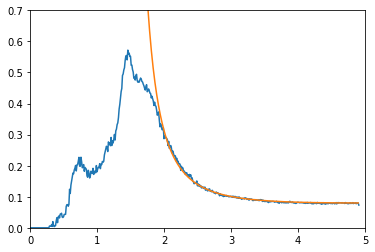

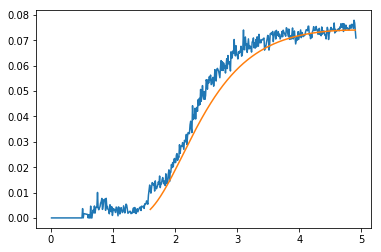

In [167]:
n = 500      # grid number
rmax = 4.9
init = np.full((2, n), 0) 
#R = np.arange(1.4, 1.55, 0.05)   # bare radius of dPGS (nm)
R = 1.6

name = "nacl-150mM"

#dist, den_mg = parse_data(files_to_read[name + "-mg"])
dist, den_na = parse_data(files_to_read[name + "-na"])
dist, den_cl = parse_data(files_to_read[name + "-cl"])
#distc, mg_cum= parse_data(files_to_read[name + "-mgcum"])
#distc, na_cum= parse_data(files_to_read[name + "-nacum"])

ca_conc, na_conc, cl_conc = systems[name]  
 
r = np.linspace(R, rmax, n)
    
e_d = -z_d * lb / R**2       # left boundary condition

res = integrate.solve_bvp(poisson_boltzmann, bc, r, init)#, verbose = 2)

result = res.sol(r)

rho_mg = [] # Local density of ions
rho_na = []
rho_cl = []

for j in range(len(r)):
    
    #rho_mg.append(rho(q_ca, ca_conc, result[0][j])/q_ca)
    rho_na.append(rho(q_na, na_conc, result[0][j])/q_na)
    rho_cl.append(rho(q_cl, cl_conc, result[0][j])/q_cl)

plt.figure()

#plt.plot(dist, den_mg)
#plt.plot(r, rho_mg )
#plt.axis([0, 5, 0, 0.2])
plt.show()

plt.plot(dist, den_na)
plt.plot(r, rho_na )
plt.axis([0, 5, 0, 0.7])
plt.show()

plt.plot(dist, den_cl)
plt.plot(r, rho_cl )
#plt.axis([0, 5, 0, 0.2])
plt.show()


#======= appending zero values at start of profile =========#

new_r_till_zero = np.linspace(r[0], 0.0, retstep = -dr)#, endpoint=False)

reversed_r = np.flip(new_r_till_zero[0])

r_last_element_popped = np.delete(reversed_r, -1)

rfinal = np.concatenate((r_last_element_popped, r), axis=0)

#rho_mg_final = np.concatenate(([0]*len(r_last_element_popped), rho_mg), axis=0)  
rho_na_final = np.concatenate(([0]*len(r_last_element_popped), rho_na), axis=0) 
rho_cl_final = np.concatenate(([0]*len(r_last_element_popped), rho_cl), axis=0) 

#===========================================================#
'''
with open(files_to_write[name + "-mg"], "w") as file:
    for i in range(len(rfinal)):
        file.write('%8.8f\t %8.8f\n' %(rfinal[i], rho_mg_final[i])) # pb
        
with open(files_to_write[name + "-na"], "w") as file:
    for i in range(len(rfinal)):
        file.write('%8.8f\t %8.8f\n' %(rfinal[i], rho_na_final[i])) # pb
        
with open(files_to_write[name + "-cl"], "w") as file:
    for i in range(len(rfinal)):
        file.write('%8.8f\t %8.8f\n' %(rfinal[i], rho_cl_final[i])) # pb
'''      

#========================= ION PROFILE WRITING END ====================================



n_mg = [] # Local number of ions
n_na = []
n_cl = []

N_mg = [] # Cumulative number of ions
N_na = []
N_cl = []

for j in range(len(rfinal)):
    
   # n_mg.append(rho_mg[j]*4*np.pi*(r[j]**2)) # local charge densities not number densities
    n_na.append(rho_na_final[j]*4*np.pi*(rfinal[j]**2))
    n_cl.append(rho_cl_final[j]*4*np.pi*(rfinal[j]**2))
    

# Calculating cumulative number of ions from their density distributions

dr = rfinal[1] - rfinal[0]

for i in range(1, len(rfinal)):
    
    #N_mg.append(integrate.trapz(n_mg[0:i], r[0:i], dx = dr))
    N_na.append(integrate.trapz(n_na[0:i], rfinal[0:i], dx = dr))
    N_cl.append(integrate.trapz(n_cl[0:i], rfinal[0:i], dx = dr))
    
rnew = np.linspace(0, rmax, len(N_na))
    
#plt.figure()

#plt.plot(distc, mg_cum)
#plt.plot(rnew, N_mg )
#plt.axis([1.3, 1.8, 0, 3])
#plt.show()

#plt.plot(distc, na_cum)
#plt.plot(rnew, N_na )
#plt.axis([1.3, 1.8, 0, 10])
#plt.show()

#plt.plot(dist, den_cl)
#plt.plot(r, n_cl )
#plt.axis([0, 5, 0, 0.2])
#plt.show()

#print(N_mg[1], N_na[1], N_mg[1]/N_na[1])

#for i in range(100):
#    print("%8.3f %15.8f %15.8f %15.8f" %(rnew[i], N_mg[i], N_na[i], N_mg[i]/N_na[i])) 
    
#####################################################################
with open(files_to_write[name + "-nacum"], "w") as file:
    for i in range(len(rnew)):
        file.write('%8.8f\t %8.8f\n' %(rnew[i], N_na[i])) # pb
#####################################################################

In [119]:
3.11606000 / 8.35211000

0.3730865613599438

   Iteration    Max residual    Total nodes    Nodes added  
       1          1.70e-04          500             0       
Solved in 1 iterations, number of nodes 500, maximum relative residual 1.70e-04.
   Iteration    Max residual    Total nodes    Nodes added  
       1          3.97e-05          500             0       
Solved in 1 iterations, number of nodes 500, maximum relative residual 3.97e-05.
   Iteration    Max residual    Total nodes    Nodes added  
       1          9.06e-06          500             0       
Solved in 1 iterations, number of nodes 500, maximum relative residual 9.06e-06.
   Iteration    Max residual    Total nodes    Nodes added  
       1          1.27e-05          500             0       
Solved in 1 iterations, number of nodes 500, maximum relative residual 1.27e-05.


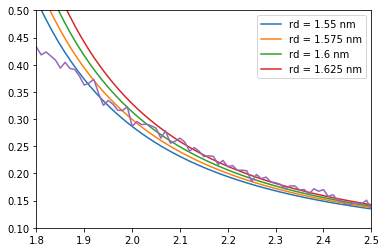

'\nplt.plot(dist, den, r, rho_mg)\nplt.axis([1.3, 3, 0., 0.4])\nplt.show()\n'

In [144]:
n = 500      # grid number
rmax = 4.9
init = np.full((2, n), 0) 
rd = np.arange(1.55, 1.65, 0.025)   # bare radius of dPGS (nm)

#rmin_fit = np.arange(1.45, 2.6, 0.1) # lower limit of the range of r to choose
                                      #for fit with simulation profile

dist, den_na = parse_data(files_to_read["nacl-150mM-na"])
dist, den_cl = parse_data(files_to_read["nacl-150mM-cl"])

obj = {}

plt.figure()

for size_dpgs in rd:
    
    ca_conc, na_conc, cl_conc = systems["nacl-150mM"]  #calc_conc(system, size_dpgs)
 
    r = np.linspace(size_dpgs, rmax, n)
    
    e_d = -z_d * lb / size_dpgs**2       # left boundary condition

    res = integrate.solve_bvp(poisson_boltzmann, bc, r, init, verbose = 2)

    result = res.sol(r)
    obj['rho_na_' + str(size_dpgs)] = []
    #obj['pot_' + str(size_dpgs)] = -result[0]
    #result[0] = result[0] - np.ones(len(r))*result[0][-1] 
    #obj['pot_' + str(size_dpgs)] =  np.log(tuple(abs(result[0]*r)))
    
    
    for j in range(len(r)):
        obj['rho_na_' + str(size_dpgs)].append(rho(q_na, na_conc, result[0][j])/q_na)
        
    '''
    #convert number density into rdf
    bulk_conc = sum(obj['rho_na_' + str(size_dpgs)][-100:])/100
    obj['rho_na_' + str(size_dpgs)] = obj['rho_na_' + str(size_dpgs)] / bulk_conc
    '''
    #residues = [] 

    #for l in rmin_fit:
        #residues.append(sum_residual(l, rmax, r, rho_mg, dist, den))
    #plt.plot(rmin_fit, residues, label = 'rd = %s nm' % np.round(size_dpgs, 3))
    
    plt.plot(r, obj['rho_na_' + str(size_dpgs)], label = 'rd = %s nm' % np.round(size_dpgs, 3))
    #plt.plot(r, obj['pot_' + str(size_dpgs)], label = 'rd = %s nm' % np.round(size_dpgs, 3))
    #plt.plot(dist, np.log(tuple(abs(pot*dist))))
    #plt.plot(dist, den)

plt.legend() 
plt.plot(dist, den_na)
plt.axis([1.8, 2.5, 0.1, 0.5])
plt.show()

'''
plt.plot(dist, den, r, rho_mg)
plt.axis([1.3, 3, 0., 0.4])
plt.show()
'''
#i1 = np.full((1, r.size), 0)
#i2 = np.full((1, r.size), 0)
#init = np.vstack((i1,i2)) # 2 rows for y and y'; r.size columns

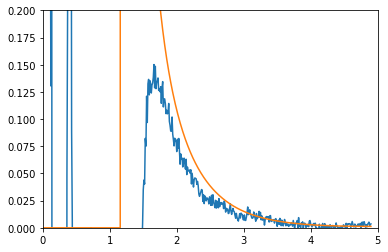

In [793]:
dist1, den_mg   = parse_data("/home/rohit/magnesium/eccr-15mM-mg/den/mg.den.xvg")
dist2, den_na   = parse_data("/home/rohit/magnesium/eccr-15mM-mg/den/na.den.xvg")
dist3, den_cl   = parse_data("/home/rohit/magnesium/eccr-15mM-mg/den/cl.den.xvg")

distx, den_x   = parse_data("/home/rohit/magnesium/eccr-15mM-mg/den/charge_density.xvg")

dist4, den_mgpb = parse_data("/home/rohit/magnesium/pb-plots/eccr-15mM-mg/mg-den-ref/mg-den.xvg")
dist5, den_napb = parse_data("/home/rohit/magnesium/pb-plots/eccr-15mM-mg/mg-den-ref/na-den.xvg")
dist6, den_clpb = parse_data("/home/rohit/magnesium/pb-plots/eccr-15mM-mg/mg-den-ref/cl-den.xvg")

den   = np.array(den_mg)*2 + np.array(den_na) - np.array(den_cl)
denpb = np.array(den_mgpb)*2 + np.array(den_napb) - np.array(den_clpb)

plt.plot(distx, den_x, dist4, denpb)
plt.axis([0, 5, -0, 0.2])
plt.show()
'''
plt.plot(dist1, den_cl, dist4, den_clpb)
plt.axis([0, 5, 0, 0.5])
plt.show()
'''



In [754]:
size_dpgs = 1.80
ca_conc, na_conc, cl_conc = calc_conc(system, size_dpgs)
r = np.linspace(size_dpgs, rmax, n)
e_d = -z_d * lb / size_dpgs**2       # left boundary condition

res = integrate.solve_bvp(poisson_boltzmann, bc, r, init)#, verbose = 2)

result = res.sol(r)

#========================= POTENTIAL START =============================================

pot = []
dist, pot = parse_data(files_to_read[pot_file])

#plt.plot(r, tuple(abs(result[0]))) # potential
#plt.plot(dist, pot)
'''
plt.plot(r, np.log(tuple(abs(result[0]*r))),'b--') # log linear potential
plt.plot(dist, np.log(tuple(abs(pot*dist))))
plt.axis([1., 2.6, -1., 1.5])
plt.ylabel('e*beta*phi')
plt.show()

'''
with open(files_to_write[pot_file], "w") as file:
    
    for i in range(len(r)):
        file.write('%8.8f\t %8.8f\n' %(r[i], result[0][i])) # pb


#========================= POTENTIAL END =============================================




#========================= ION PROFILE WRITING START =============================================



rho_mg = [] # Local density of ions
rho_na = []
rho_cl = []


for j in range(len(r)):
    
    rho_mg.append(rho(q_ca, ca_conc, result[0][j])/q_ca)
    rho_na.append(rho(q_na, na_conc, result[0][j])/q_na)
    rho_cl.append(rho(q_cl, cl_conc, result[0][j])/q_cl)

bulk_mg = np.sum(rho_mg[-100:])/100
bulk_na = np.sum(rho_na[-100:])/100
bulk_cl = np.sum(rho_cl[-100:])/100

rdf_mg = rho_mg/bulk_mg
rdf_na = rho_na/bulk_na
rdf_cl = rho_cl/bulk_cl

#======= appending zero values at start of profile =========#

new_r_till_zero = np.linspace(r[0], 0.0, retstep = -dr)#, endpoint=False)

reversed_r = np.flip(new_r_till_zero[0])

r_last_element_popped = np.delete(reversed_r, -1)

rfinal = np.concatenate((r_last_element_popped, r), axis=0)

rdf_mg_final = np.concatenate(([0]*len(r_last_element_popped), rdf_mg), axis=0)  
rdf_na_final = np.concatenate(([0]*len(r_last_element_popped), rdf_na), axis=0) 
rdf_cl_final = np.concatenate(([0]*len(r_last_element_popped), rdf_cl), axis=0) 

#===========================================================#

with open(files_to_write[mgfile], "w") as file:
    
    for i in range(len(rfinal)):
        file.write('%8.8f\t %8.8f\n' %(rfinal[i], rdf_mg_final[i])) # pb
        
        
with open(files_to_write[nafile], "w") as file:
    for i in range(len(rfinal)):
        file.write('%8.8f\t %8.8f\n' %(rfinal[i], rdf_na_final[i])) # pb
        
        
with open(files_to_write[clfile], "w") as file:
    for i in range(len(rfinal)):
        file.write('%8.8f\t %8.8f\n' %(rfinal[i], rdf_cl_final[i])) # pb
        

        
#========================= ION PROFILE WRITING END =============================================


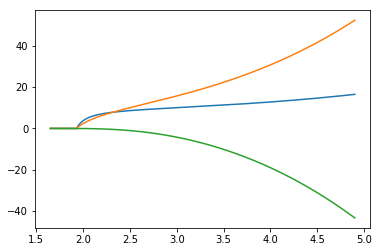

1.5547705129516345

In [546]:
n_mg = [] # Local number of ions
n_na = []
n_cl = []

N_mg = [] # Cumulative number of ions
N_na = []
N_cl = []

for j in range(len(rfinal)):
    
    n_mg.append(rho_mg_final[j]*q_ca*4*np.pi*(rfinal[j]**2)) # local charge densities not number densities
    n_na.append(rho_na_final[j]*q_na*4*np.pi*(rfinal[j]**2))
    n_cl.append(rho_cl_final[j]*q_cl*4*np.pi*(rfinal[j]**2))
    

# Calculating cumulative number of ions from their density distributions

dr = rfinal[1] - rfinal[0]

for i in range(1, len(rfinal)):
    
    N_mg.append(integrate.trapz(n_mg[0:i], rfinal[0:i], dx = dr))
    N_na.append(integrate.trapz(n_na[0:i], rfinal[0:i], dx = dr))
    N_cl.append(integrate.trapz(n_cl[0:i], rfinal[0:i], dx = dr))

r_new = np.linspace(size_dpgs, rmax, len(N_na))

list_of_lists = [N_mg, N_na, N_cl]

zacc = [sum(x)+z_d for x in zip(*list_of_lists)]

#plt.plot(r_new, zacc) 
plt.plot(r_new, N_mg, r_new, N_na, r_new, N_cl) 
plt.show()
N_mg[-1] + N_na[-1] + N_cl[-1] + -24

#### since the positively charged counterions have no access to reside in the spherical dPGS volume, they are swept away due to excluded volume interaction with hard sphere and thus have more cumulative number than simulations.

In [168]:
def parse_data(data_file):

    with open(data_file) as file:
        
        lines = file.readlines()

    a = ([line.strip().split() for line in lines])

# turn array strings into numbers
    
    b = np.array(a)
    u = b.astype(np.float)

    r = u[:,0] # radial distance
    c = u[:,1] # charge density

    #return np.vstack((r, c))
    return r, c

In [34]:
def z_dpgs(r, size_dpgs): # assumes lB is constant throughout - epsilon is constant throughout
    
    z = z_d*(1 - np.heaviside(r - size_dpgs, 0))
    #cs = c_s*rd/3*( np.heaviside(r - rd + 0.00789, 1) - np.heaviside(r - rd - 0.00789, 1) )
    return z

def rho(charge, bulk_conc, phi):
    return charge * bulk_conc * np.exp(-charge * phi)

def poisson_boltzmann(r, y):
    
# y[0] = phi potential 
# y[1] = d_phi/dr electric field 
# r = radial distance
    
    y2 = -factor*(rho(q_ca, ca_conc, y[0]) + rho(q_na, na_conc, y[0]) + rho(q_cl, cl_conc, y[0])) - 2*y[1]/r
    
    return np.vstack((y[1], y2))

In [3]:
# boundary condition residuals
def bc(ya, yb):
    # ya = [y(a), y'(a), y''(a)]
    # yb = [y(b), y'(b), y''(b)]
    return np.array([ya[1] - e_d , yb[1]]) # Neumann 
    #return np.array([ya[1] - e_d , yb[0]]) # Mixed
    #return np.array([ya[0] - phi_d , yb[0]]) # Dirichlet 

In [322]:
def sum_residual(rmin, rmax, r, rho_mg, dist, sim_den): # it takes pb fit and simulation den, 
    # creates equal data points by interpolation and evaluates the residual
    
    rnew = np.linspace(rmin, rmax, 300)

    tck1 = interpolate.splrep(r, rho_mg)
    rho_mg_new = interpolate.splev(rnew, tck1)

    tck2 = interpolate.splrep(dist, sim_den)
    den_new = interpolate.splev(rnew, tck2)

    sum_residual = np.sum( (rho_mg_new - den_new)**2 )
    
    return sum_residual

In [330]:
#dist, den = parse_data("/home/rohit/magnesium/netz-15mM-mg/den/mg.den.xvg")  
        
'''
dist, pot = parse_data("/home/rohit/magnesium/eccr-15mM-mg/potential.xvg")
plt.plot(r, tuple(result[0])) # potential
#plt.plot(r, np.log(tuple(abs(result[0]*r))),'b--') # log linear potential
plt.plot(dist, -pot)
plt.ylabel('e*beta*phi')
plt.show()

with open("/home/rohit/magnesium/pb-plots/eccr-15mM/pot_0_1rd.xvg", "w") as file:
    for i in range(len(r)):
        file.write('%8.8f\t %8.8f\n' %(r[i], result[0][i])) # pb
    file.write('&\n')
    for i in range(len(dist)):
        file.write('%8.8f\t %8.8f\n' %(dist[i], -pot[i])) # simulation
          
    

rho_mg = [] # Local density of ions
rho_na = []
rho_cl = []

for j in range(len(r)):
    
    rho_mg.append(rho(q_ca, ca_conc, result[0][j])/q_ca)
    rho_na.append(rho(q_na, na_conc, result[0][j])/q_na)
    rho_cl.append(rho(q_cl, cl_conc, result[0][j])/q_cl)

    
# Density profiles 

plt.plot(r, rho_mg)
dist, den = parse_data("/home/rohit/magnesium/eccr-15mM-mg/den/mg.den.xvg")
plt.plot(dist, den)
plt.ylabel('rho_mg')
plt.axis([1.5, 5.0, 0.005, 0.02])
plt.show()


rmin = np.arange(1.5, 3.05, 0.05)
residues = [] 

for l in rmin:
    residues.append(sum_residual(l, rmax, r, rho_mg, dist, den))

plt.figure()
plt.plot(rp, residues)
plt.show()




with open("/home/rohit/magnesium/pb-plots/eccr-15mM/mg_0_1rd.xvg", "w") as file:
    for i in range(len(r)):
        file.write('%8.8f\t %8.8f\n' %(r[i], rho_mg[i])) # pb
    file.write('&\n')
    for i in range(len(dist)):
        file.write('%8.8f\t %8.8f\n' %(dist[i], den[i])) # simulation
        

dist, den = parse_data("/home/rohit/magnesium/eccr-15mM-mg/den/na.den.xvg")
plt.plot(r, rho_na)
plt.plot(dist, den)
plt.ylabel('rho_na')
plt.axis([2.0, 5.0, 0.07, 0.12])
plt.show()

with open("/home/rohit/magnesium/pb-plots/eccr-15mM/na_0_1rd.xvg", "w") as file:
    for i in range(len(r)):
        file.write('%8.8f\t %8.8f\n' %(r[i], rho_na[i]))
    file.write('&\n')
    for i in range(len(dist)):
        file.write('%8.8f\t %8.8f\n' %(dist[i], den[i]))

dist, den = parse_data("/home/rohit/magnesium/eccr-15mM-mg/den/cl.den.xvg")
plt.plot(r, rho_cl)
plt.plot(dist, den)
plt.ylabel('rho_cl')
#plt.axis([1.0, 5.0, 0.06, 0.11])
plt.show()

with open("/home/rohit/magnesium/pb-plots/eccr-15mM/cl_0_1rd.xvg", "w") as file:
    for i in range(len(r)):
        file.write('%8.8f\t %8.8f\n' %(r[i], rho_cl[i]))
    file.write('&\n')
    for i in range(len(dist)):
        file.write('%8.8f\t %8.8f\n' %(dist[i], den[i]))



plt.plot(r, np.log(tuple(abs(result[0]*r))),'b--') # log linear potential
plt.ylabel('log|r*e*beta*phi|')
plt.show()



n_mg = [] # Local number of ions
n_na = []
n_cl = []

N_mg = [] # Cumulative number of ions
N_na = []
N_cl = []

for j in range(len(r)):
    
    n_mg.append(rho_ca[j]*4*np.pi*(r[j]**2))
    n_na.append(rho_na[j]*4*np.pi*(r[j]**2))
    n_cl.append(rho_cl[j]*4*np.pi*(r[j]**2))
    

# Calculating cumulative number of ions from their density distributions

dr = r[1] - r[0]

for i in range(1, len(r)):
    
    N_mg.append(integrate.trapz(n_ca[0:i], r[0:i], dx = dr))
    N_na.append(integrate.trapz(n_na[0:i], r[0:i], dx = dr))
    N_cl.append(integrate.trapz(n_cl[0:i], r[0:i], dx = dr))

r_new = np.linspace(size_dpgs, rmax, len(N_na))

zacc = N_mg + N_na + N_cl + z_d

plt.plot(r_new, N_ca,'r-') 
plt.ylabel('N_Ca')
plt.show()


# Cumulative number of ions
plt.plot(r_new, N_ca,'r-') 
plt.ylabel('N_Ca')
plt.show()

plt.plot(r_new, N_na,'b-') 
plt.ylabel('N_Na')
plt.show()

plt.plot(r_new, N_cl,'g-') 
plt.ylabel('N_cl')
plt.show()

'''

'\ndist, pot = parse_data("/home/rohit/magnesium/eccr-15mM-mg/potential.xvg")\nplt.plot(r, tuple(result[0])) # potential\n#plt.plot(r, np.log(tuple(abs(result[0]*r))),\'b--\') # log linear potential\nplt.plot(dist, -pot)\nplt.ylabel(\'e*beta*phi\')\nplt.show()\n\nwith open("/home/rohit/magnesium/pb-plots/eccr-15mM/pot_0_1rd.xvg", "w") as file:\n    for i in range(len(r)):\n        file.write(\'%8.8f\t %8.8f\n\' %(r[i], result[0][i])) # pb\n    file.write(\'&\n\')\n    for i in range(len(dist)):\n        file.write(\'%8.8f\t %8.8f\n\' %(dist[i], -pot[i])) # simulation\n          \n    \n\nrho_mg = [] # Local density of ions\nrho_na = []\nrho_cl = []\n\nfor j in range(len(r)):\n    \n    rho_mg.append(rho(q_ca, ca_conc, result[0][j])/q_ca)\n    rho_na.append(rho(q_na, na_conc, result[0][j])/q_na)\n    rho_cl.append(rho(q_cl, cl_conc, result[0][j])/q_cl)\n\n    \n# Density profiles \n\nplt.plot(r, rho_mg)\ndist, den = parse_data("/home/rohit/magnesium/eccr-15mM-mg/den/mg.den.xvg")\nplt.pl

##### The long range density curves cannot be fitted by PB theory, since the bulk concentration in the simulation is less than N/V due to absorption of counterion in dPGS. The solution would be to increase the number of counterions. And to keep the same concentration of counterions, box size needs to be increased.

## cumulative profiles from density profiles

In [216]:
# remove r_new axis from charge_density_to_potential.py
infile  = '/home/rohit/magnesium/mg-netz/old-mg-33mM/mg.den.xvg'
outfile = '/home/rohit/magnesium/mg-netz/old-mg-33mM/mg-cum.xvg'

r, rho_mg = parse_data(infile)

n_mg = [] # Local number of ions
n_na = []
n_cl = []

N_mg = [] # Cumulative number of ions
N_na = []
N_cl = []

for j in range(len(r)):
    
    n_mg.append(rho_mg[j]*4*np.pi*(r[j]**2))
    #n_na.append(rho_na[j]*4*np.pi*(r[j]**2))
    #n_cl.append(rho_cl[j]*4*np.pi*(r[j]**2))

# Calculating cumulative number of ions from their density distributions

dr = r[1] - r[0]

for i in range(1, len(r)):
    
    N_mg.append(integrate.trapz(n_mg[0:i], r[0:i], dx = dr))
    #N_na.append(integrate.trapz(n_na[0:i], r[0:i], dx = dr))
    #N_cl.append(integrate.trapz(n_cl[0:i], r[0:i], dx = dr))

with open(outfile, "w") as outfile:
    for i in range(1, len(r)):
        outfile.write('%8.8f\t %8.8f\n' %(r[i], N_mg[i-1]))


In [1]:
import math
def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)

N = 34
a = math.log(factorial(N))
b = N*math.log(N) - N
print(a, b)

88.58082754219768 85.89625783694949


## Debye length as a function of salt conc

In [7]:
ionic_strength = 0.13 # in Molar units
lambda_d = .304/np.sqrt(ionic_strength)
print(lambda_d)

0.8431442982623482
